In [1]:
import pandas as pd
import numpy as np

training = pd.read_csv('new train data.csv')
# pd.set_option('display.max_columns', 150)
# pd.set_option('display.max_rows', 150)

# ProductCD: product code of each transaction; there are 5 product types
training['ProductCD'].value_counts()

W    24264
C    10054
R     2719
H     2651
S     1100
Name: ProductCD, dtype: int64

In [2]:
# card4: brand of card; there are 4 brands
training['card4'].value_counts()

visa                26710
mastercard          12944
discover              609
american express      525
Name: card4, dtype: int64

In [3]:
# card6: type of card; we drop the 3 unique rows of 'debit or credit' and 'charge card'
training['card6'].value_counts()
mask = training['card6'] != 'debit or credit'
training = training[mask]
mask2 = training['card6'] != 'charge card'
training = training[mask2]
training.shape

(40785, 112)

In [4]:
# create into category type
training['card6'] = training['card6'].astype('category')
training['card4'] = training['card4'].astype('category')
training['ProductCD'] = training['ProductCD'].astype('category')

# encode into numeric categories; we opt for dummy variables (One Hot Encoding)
training_dummies = pd.get_dummies(training, columns=['card4', 'card6', 'ProductCD'])

In [5]:
from sklearn import preprocessing

# initialize scaler
scaler = preprocessing.MinMaxScaler()

# drop target column
training_v1 = training_dummies.drop('TransactionID', axis=1)
training_v2 = training_v1.drop('isFraud', axis=1)
training_y = training_dummies['isFraud'].copy()
training_id = training_dummies['TransactionID'].copy()

# Fit the data with scaler (scales data)
training_v2 = training_v2.set_index('Unnamed: 0')
x = training_v2.values
x_scaled = scaler.fit_transform(x)
training_scaled = pd.DataFrame(x_scaled)
training_scaled = training_scaled.set_axis([x for x in training_v2.columns], axis=1, inplace=False)
training_scaled.insert(loc=0, column='TransactionID', value=training_id)
training_scaled['y'] = training_y
training_scaled = training_scaled.dropna()
training_scaled['TransactionID'] = training_scaled['TransactionID'].astype(int)
training_scaled.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card3,card5,C1,C2,C3,C4,...,card4_mastercard,card4_visa,card6_credit,card6_debit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,y
0,3273604,0.443036,0.020744,0.488205,0.381679,0.919708,0.000214,0.000176,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2999170,0.016551,0.011435,0.443326,0.381679,0.919708,0.013456,0.007557,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3023872,0.053123,0.014002,0.918124,0.381679,0.919708,0.023708,0.016872,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3033043,0.064770,0.009580,0.663003,0.381679,0.905109,0.000214,0.000176,0.0,0.000444,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3422561,0.695863,0.025946,0.488205,0.381679,0.919708,0.000641,0.000351,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# initialize Random Forest model and split data into training and validation
clf = RandomForestClassifier()
y = training_scaled['y'].copy()
training_scaled = training_scaled.drop(['y'], axis=1)
x = training_scaled.drop(['TransactionID'], axis=1)
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=42)

In [7]:
from sklearn.model_selection import cross_val_score
# fit our data to the model and cross-validate for accuracy
rffit = clf.fit(x_train, y_train)
rf_acc_scores = cross_val_score(rffit, x_train, y_train, scoring='accuracy', cv=5)

C:\Users\tsblo\Anaconda2\envs\p36workshop\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [8]:
# function to display mean accuracy and standard deviation of accuracy
def display_scores(scores):
    print('mean:', scores.mean())
    print('std dev:', scores.std())
display_scores(rf_acc_scores)

mean: 0.8097170448136677
std dev: 0.00481900275535411


In [9]:
# %%time
# # K-Fold CV to optimize tuning parameters
# from sklearn.model_selection import GridSearchCV
# param_grid = [{'max_depth': [10, 20, 30, 40],
#  'min_samples_split': [5, 7],
#  'n_estimators': [200, 400]}]

# grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=3)

# grid_search.fit(x_train, y_train)
# grid_search.best_params_

In [10]:
clf = RandomForestClassifier(max_depth=30, min_samples_split=7, n_estimators=200)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
y_pred = clf.predict(x_val)
accuracy_score(y_val, y_pred)

0.8324833267948215

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, x_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[12968,  2342],
       [ 3072, 12204]], dtype=int64)

In [13]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train, y_train_pred))
recall_score(y_train, y_train_pred)

0.8389935377423346


0.7989002356637863

In [14]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(x_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Figure size 640x480 with 1 Axes>

In [15]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                    index = x_train.columns,
                                    columns= ['importance']).sort_values('importance',ascending=False)
feature_importances[:10]

,importance
TransactionDT,0.053360
TransactionAmt,0.048273
C13,0.047810
C14,0.046166
card1,0.041789
C1,0.031428
C5,0.031052
C8,0.030028
C4,0.029280
C2,0.028137


# MLP Model

In [16]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

In [17]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [18]:
# from sklearn.model_selection import GridSearchCV

# mlp_clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, verbose = 3)
# mlp_clf.fit(x_train, y_train)

In [19]:
# # Best paramete set
# print('Best parameters found:\n', mlp_clf.best_params_)

In [21]:
mlp_clf = MLPClassifier(activation = 'relu', alpha = 0.0001, hidden_layer_sizes = (50, 100, 50), \
                        learning_rate = 'constant', solver = 'adam', verbose = 3)
mlp_clf.fit(x_train, y_train)

Iteration 1, loss = 0.58600990
Iteration 2, loss = 0.54690729
Iteration 3, loss = 0.52779168
Iteration 4, loss = 0.52191258
Iteration 5, loss = 0.51196330
Iteration 6, loss = 0.50532572
Iteration 7, loss = 0.49901147
Iteration 8, loss = 0.49073072
Iteration 9, loss = 0.48580678
Iteration 10, loss = 0.48039610
Iteration 11, loss = 0.47571893
Iteration 12, loss = 0.47278213
Iteration 13, loss = 0.46909351
Iteration 14, loss = 0.46599814
Iteration 15, loss = 0.45946759
Iteration 16, loss = 0.45755248
Iteration 17, loss = 0.45470762
Iteration 18, loss = 0.45258647
Iteration 19, loss = 0.44888015
Iteration 20, loss = 0.44859374
Iteration 21, loss = 0.44751235
Iteration 22, loss = 0.44312291
Iteration 23, loss = 0.43924699
Iteration 24, loss = 0.43777623
Iteration 25, loss = 0.43608459
Iteration 26, loss = 0.43256649
Iteration 27, loss = 0.43380674
Iteration 28, loss = 0.43120191
Iteration 29, loss = 0.43156399
Iteration 30, loss = 0.42478176
Iteration 31, loss = 0.42771606
Iteration 32, los

C:\Users\tsblo\Anaconda2\envs\p36workshop\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=3, warm_start=False)

In [22]:
y_pred = clf.predict(x_val)
accuracy_score(y_val, y_pred)

0.8324833267948215

In [23]:
print(precision_score(y_train, y_train_pred))
recall_score(y_train, y_train_pred)

0.8389935377423346


0.7989002356637863

# Calibration Curve

In [30]:
mlp_clf = MLPClassifier(activation = 'relu', alpha = 0.0001, hidden_layer_sizes = (50, 100, 50), \
                        learning_rate = 'constant', solver = 'adam')

rf_clf = RandomForestClassifier(max_depth=30, min_samples_split=7, n_estimators=200)

C:\Users\tsblo\Anaconda2\envs\p36workshop\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


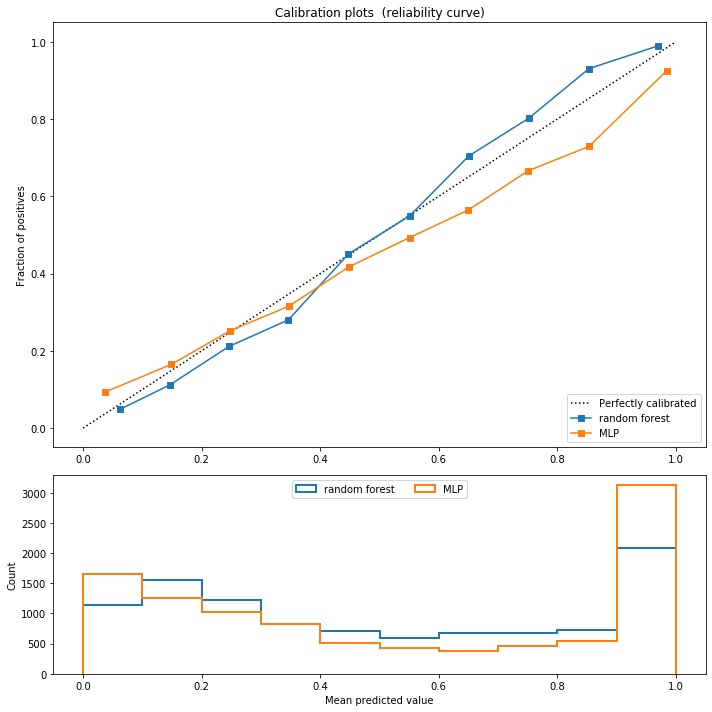

In [31]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(rf_clf, 'random forest'),
                  (mlp_clf, 'MLP')]:

    clf.fit(x_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(x_val)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(x_val)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_val, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

# Adjusting the classification threshold

In [ ]:
# store the predicted probabilities for class 1
y_pred_prob = rf_clf.predict_proba(x_val)[:, 1]

In [ ]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# adjust the font size 
plt.rcParams['font.size'] = 12

In [ ]:
# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of fraud')
plt.ylabel('Frequency')

In [ ]:
# # predict fraud if the predicted probability is greater than 0.3
# from sklearn.preprocessing import binarize
# # it will return 1 for all values above 0.3 and 0 otherwise
# # results are 2D so we slice out the first column
# y_pred_class = binarize(y_pred_prob, 0.3)[0]